In [ ]:
# Setup working directory so everything runs smoothly
import os
working_directory = '/Users/stevenhamel/Dropbox/My Mac (Steven’s MacBook Pro (2))/Documents/Projects/qpath_unet'
os.chdir(working_directory)

Here we present a step-by-step tutorial on the use of `histolab` to extract a tile dataset from example WSIs retrieve from the [TCGA repository](https://portal.gdc.cancer.gov/).

## TCGA data
First things first, let’s import some data to work with, for example the prostate tissue slide and the ovarian tissue slide available in the `data` module:

In [ ]:
from histolab.data import prostate_tissue, ovarian_tissue

<div class="alert alert-block alert-info">
<b>Note:</b> To  use  the <mark>data</mark>  module,  you  need  to  install <mark><a href=”https://pypi.org/project/pooch/">pooch</a></mark>. This step is needless if we are using the Vagrant/Docker virtual environment.</div>

The call to a  `data` function will automatically download the WSIs from the corresponding repository and save the slide in a cached directory:

In [ ]:
# prostate_svs, prostate_path = prostate_tissue()
# ovarian_svs, ovarian_path = ovarian_tissue()

In [ ]:
# Set up path to images
tissue = 'R1030'
qpun_path = f"images/merad_lab_images/{tissue}/{tissue}T_HE.svs"

Notice that each  `data` function outputs the corresponding slide, as an *OpenSlide* object, and the path where the slide has been saved.

## Slide initialization

`histolab` maps a WSI file into a `Slide` object. Each usage of a WSI requires a 1-o-1 association with a `Slide` object contained in the `slide` module:

In [ ]:
from histolab.slide import Slide
from histolab.tiler import GridTiler

To initialize a `Slide` it is necessary to specify the WSI path, and the `processed_path` where the thumbnail and the tiles will be saved. In our example, we want the `processed_path` of each slide to be a subfolder of the current working directory:

In [ ]:
BASE_PATH = os.getcwd()


# PROCESS_PATH_PROSTATE = os.path.join(BASE_PATH, 'prostate', 'processed')
# PROCESS_PATH_OVARIAN = os.path.join(BASE_PATH, 'ovarian', 'processed')
PROCESS_PATH_QPUN = os.path.join(BASE_PATH,'images','histolab','R1024', 'processed')
os.makedirs(PROCESS_PATH_QPUN, exist_ok=True)

# prostate_slide = Slide(prostate_path, processed_path=PROCESS_PATH_PROSTATE)
# ovarian_slide = Slide(ovarian_path, processed_path=PROCESS_PATH_OVARIAN)
qpun_slide = Slide(qpun_path, processed_path=PROCESS_PATH_QPUN)

<div class="alert alert-block alert-info">
<b>Note:</b> If our slides were stored in the same folder, this can be done directly on the whole dataset by calling the <mark>SlideSet</mark> object of the <mark>slide</mark> module.</div>

With a `Slide` object we can easily retrieve information about the slide, such as the slide name, the number of available levels, the dimensions at native magnification or at a specified level:

In [12]:
print(f"Slide name: {qpun_slide.name}")
print(f"Levels: {qpun_slide.levels}")
print(f"Dimensions at level 0: {qpun_slide.dimensions}")
print(f"Dimensions at level 1: {qpun_slide.level_dimensions(level=1)}")
print(f"Dimensions at level 2: {qpun_slide.level_dimensions(level=2)}")

Slide name: R1030T_HE
Levels: [0, 1, 2]
Dimensions at level 0: (25896, 15638)
Dimensions at level 1: (6474, 3909)
Dimensions at level 2: (3237, 1954)


Moreover, we can save and show the slide thumbnail in a separate window. In particular, the thumbnail image will be automatically saved in a subdirectory of the `processed_path`:


In [ ]:
qpun_slide.thumbnail
qpun_slide.show()

## Tiles extraction

Once that our `Slide` objects are defined, we can proceed to extract the tiles. To speed up the extraction process, `histolab` automatically detects the tissue region with the largest connected area and crops the tiles within this field. The `tiler` module implements different strategies for the tiles extraction and provides an intuitive interface to easily retrieve a tile dataset suitable for our task. In particular, each extraction method is customizable with several common parameters:

P1) `tile_size`: the tile size;

P2) `level`: the extraction level (from 0 to the number of available levels);

P3) `check_tissue`: if a minimum percentage of tissue is required to save the tiles (default is 80\%);

P4) `prefix`: a prefix to be added at the beginning of the tiles' filename (default is the empty string);

P5) `suffix`: a suffix to be added to the end of the tiles' filename (default is `.png`).

### Random extraction

The simplest approach we may adopt is to randomly crop a fixed number of tiles from our slides; in this case, we need the `RandomTiler` extractor:

In [ ]:
from histolab.tiler import RandomTiler

Let's suppose that we want to randomly extract 6 squared tiles at level 2 of size 512 from our prostate slide, and that we want to save them only if they have at least 80\% of tissue inside. We then initialize our `RandomTiler` extractor as follows:

In [ ]:
random_tiles_extractor = RandomTiler(
    tile_size=(512, 512),
    n_tiles=6,
    level=2,
    seed=42,
    check_tissue=True, # default 
    prefix=tissue, # save tiles in the "random" subdirectory of slide's processed_path
    suffix=".png" # default
)

Notice that we also specify the random seed to ensure the reproducibility of the derived dataset.

Starting the extraction is as simple as calling the `extract` method on our slide:

In [ ]:
random_tiles_extractor.extract(qpun_slide)


### Grid extraction

Instead of picking tiles at random, we may want to retrieve all the tiles available. The `GridTiler` extractor crops the tiles following a grid structure on the largest tissue region detected in the WSI:

In [ ]:
from histolab.tiler import GridTiler

In our example, we want to extract squared tiles at level 0 of size 512 from our ovarian slide, independently of the amount of tissue detected. By default, tiles will not overlap, namely the parameter defining the number of overlapping pixels between two adjacent tiles, `pixel_overlap`, is set to zero:

In [ ]:
grid_tiles_extractor = GridTiler(
    tile_size=(512, 512),
    level=0, 
    check_tissue=True, 
    pixel_overlap=0, # default 
    prefix=tissue+"_grid_", # save tiles in the "grid" subdirectory of slide's processed_path 
    suffix=".png" # default
)

In [ ]:
grid_tiles_extractor.locate_tiles(
    slide=qpun_slide,#extraction_mask=True,
    scale_factor=64,
    alpha=64,
    outline="#046C4C",
)


In [11]:
x = [ print(i,'  ') for i in dir(grid_tiles_extractor)]

__abstractmethods__   
__annotations__   
__class__   
__class_getitem__   
__delattr__   
__dict__   
__dir__   
__doc__   
__eq__   
__format__   
__ge__   
__getattribute__   
__gt__   
__hash__   
__init__   
__init_subclass__   
__le__   
__lt__   
__module__   
__ne__   
__new__   
__parameters__   
__reduce__   
__reduce_ex__   
__repr__   
__setattr__   
__sizeof__   
__slots__   
__str__   
__subclasshook__   
__weakref__   
_abc_impl   
_are_coordinates_within_extraction_mask   
_grid_coordinates_from_bbox_coordinates   
_grid_coordinates_generator   
_has_valid_tile_size   
_is_protocol   
_is_runtime_protocol   
_n_tiles_column   
_n_tiles_row   
_tile_filename   
_tiles_generator   
_valid_tile_size   
_validate_level   
_validate_tile_size   
check_tissue   
extract   
level   
locate_tiles   
pixel_overlap   
prefix   
suffix   
tile_size   
tissue_percent   


In [13]:
grid_tiles_extractor._tiles_generator(qpun_slide)

<generator object GridTiler._tiles_generator at 0x7f802daf0970>

In [ ]:

linebreak = '_='.join(['']*30)
newline = '\n'
print()

gtegen_gcg = grid_tiles_extractor._grid_coordinates_generator(qpun_slide)
gtegen_tg = grid_tiles_extractor._tiles_generator(qpun_slide)

print(grid_tiles_extractor.tissue_percent)

x = []
y = []
x_tile = []
y_tile = []
for gridcoordgen in gtegen_gcg:
#     print(gridcoordgen,'||',gridtilegen)
    x.append(gridcoordgen.x_ul)
    y.append(gridcoordgen.y_ul)
    
    
#     if n>8:
#         break
for gridtilegen in gtegen_tg:
    x_tile.append(gridtilegen[-1].x_ul)
    y_tile.append(gridtilegen[-1].y_ul)
    

import numpy as np
import matplotlib.pyplot as plt
c= np.random.randint(0,50,len(x))
size=10
plt.scatter(x,y,s=size,c=c,marker='s')
plt.axis('square')
plt.show()

c= np.random.randint(0,50,len(x_tile))
plt.scatter(x_tile,y_tile,s=size,c=c,marker='s')
plt.axis('square')
plt.show()

In [ ]:
gtegen_tg = grid_tiles_extractor._tiles_generator(qpun_slide)
x_tile_ul = []
y_tile_ul = []
x_tile_br = []
y_tile_br = []
for gridtilegen in gtegen_tg:
    x_tile_ul.append(gridtilegen[-1].x_ul)
    y_tile_ul.append(gridtilegen[-1].y_ul)
    x_tile_br.append(gridtilegen[-1].x_br)
    y_tile_br.append(gridtilegen[-1].y_br)


Again, the extraction process starts when the extract method is called on our slide:

In [ ]:
grid_tiles_extractor.extract(qpun_slide)

### Score-based extraction

According to the task addressed, the tiles extracted may not be equally informative.

The `ScoreTiler` allows us to save only the "best" tiles, among all the ones extracted with a grid structure, based on a specific scoring function. 

For example, let's suppose that our goal is the detection of mitotic activity on our ovarian slide. In this case, tiles with a higher presence of nuclei are preferable over tile with little or no nuclei. We can leverage the `NucleiScorer` function of the `scorer` module to order the extracted tiles based on the proportion of the tissue and of the hematoxylin staining.

In particular, the score is computed as $N_t\cdot\mathrm{tanh}(T_t)$, where $N_t$ is the percentage of nuclei and $T_t$ the percentage of tissue in the tile $t$.

First, we need the extractor and the scorer:

In [ ]:
from histolab.tiler import ScoreTiler
from histolab.scorer import NucleiScorer
import histolab.scorer

In [ ]:
histolab.scorer

As the `ScoreTiler` extends the `GridTiler` extractor, we also set the `pixel_overlap` as additional parameter. Moreover, we can specify the number of the top tiles we want to save with the `n_tile` parameter:

In [ ]:
scored_tiles_extractor = ScoreTiler(
    scorer = NucleiScorer(),
    tile_size=(512, 512),
    n_tiles=6, 
    level=0,
    check_tissue=True, 
    pixel_overlap=0, # default 
    prefix=tissue+"_scored_", # save tiles in the "scored" subdirectory of slide's processed_path 
    suffix=".png" # default
)

Finally, when we extract our cropped images, we can also write a report of the saved tiles and their scores in a CSV file:

In [ ]:
summary_filename = "summary_qpun_tiles.csv"
SUMMARY_PATH = os.path.join(qpun_slide.processed_path, summary_filename)

scored_tiles_extractor.extract(qpun_slide, report_path=SUMMARY_PATH)

In [ ]:
NucleiScorer()

# test run

#### import statements

In [1]:
from histolab.slide import Slide
from histolab.tiler import GridTiler
import os

#### input

In [2]:
# Set up path to images
tissue = 'R1030'
working_directory = '/Users/stevenhamel/Dropbox/My Mac (Steven’s MacBook Pro (2))/Documents/Projects/qpath_unet'
image_path = f"images/merad_lab_images/{tissue}/{tissue}T_HE.svs"

#### Set paths

In [3]:
os.chdir(working_directory)
BASE_PATH = os.getcwd()
PROCESS_PATH_QPUN = os.path.join(BASE_PATH,'images','histolab',tissue, 'processed')
os.makedirs(PROCESS_PATH_QPUN, exist_ok=True)

#### Slide object

In [4]:
qpun_slide = Slide(image_path, processed_path=PROCESS_PATH_QPUN)

#### Grid extractor

In [5]:
grid_tiles_extractor = GridTiler(
    tile_size=(512, 512),
    level=0, 
    check_tissue=True, 
    pixel_overlap=0, # default 
    prefix=tissue+"_grid_", # save tiles in the "grid" subdirectory of slide's processed_path 
    suffix=".png" # default
)


In [6]:
gtegen_tg = grid_tiles_extractor._tiles_generator(qpun_slide)
x_tile_ul = []
y_tile_ul = []
x_tile_br = []
y_tile_br = []
for gridtilegen in gtegen_tg:
    x_tile_ul.append(gridtilegen[-1].x_ul)
    y_tile_ul.append(gridtilegen[-1].y_ul)
    x_tile_br.append(gridtilegen[-1].x_br)
    y_tile_br.append(gridtilegen[-1].y_br)


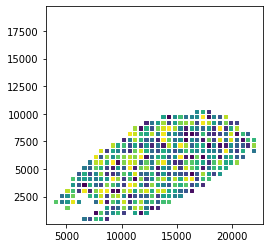

In [9]:
import numpy as np
import matplotlib.pyplot as plt
c = np.random.randint(0,50,len(x_tile_ul))
size = 10
ymax = np.max(y_tile_ul)+512
y_tile_ul_flipped = [ymax-y_tile_ul_i for y_tile_ul_i in y_tile_ul]

plt.scatter(x_tile_ul,y_tile_ul_flipped,s=size,c=c,marker='s')
plt.axis('square')
plt.show()

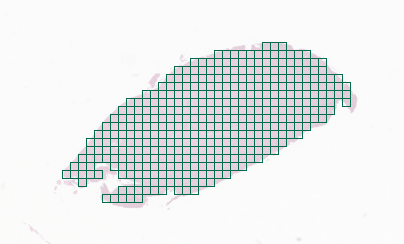

In [14]:
grid_tiles_extractor.locate_tiles(
    slide=qpun_slide,
    scale_factor=64,
    alpha=64,
    outline="#046C4C",
)


# SlideIO

In [15]:
pip install slideio

     |████████████████████████████████| 18.8 MB 3.9 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [17]:
import slideio
slide = slideio.open_slide("images/merad_lab_images/R1030/R1030T_HE.svs", "SVS")
scene = slide.get_scene(0)
image = scene.read_block((0,0,10000,10000), (500,500))

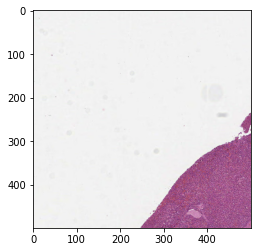

In [18]:
plt.imshow(image)